In [1]:
import pandas as pd
from os.path import join, isdir

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from icecream import ic
from src.utils import variant_utils as vu
from glob import glob

In [2]:
don_dir = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/v2_MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/"
outdir = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/v2_MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/mt_clones/thr__0.1_rt__25/"
samples = "preB,postB"
mt_genome="/data/Mito_Trace/data/external/GRCh38_MT_blacklist/chrM.fasta"
t=0.1
rt=25
n_donors = 4


In [3]:
don_dirs = [d for d in glob(don_dir + "/donor*") if isdir(d)]
don_dirs = {int(x.split("donor")[-1]):x for x in don_dirs}
don_dirs = {x:don_dirs[x] for x in don_dirs if x in range(n_donors)}
don_dirs

{3: '/data/Mito_Trace/output/pipeline/DUPI_april08_2021/v2_MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor3',
 0: '/data/Mito_Trace/output/pipeline/DUPI_april08_2021/v2_MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor0',
 1: '/data/Mito_Trace/output/pipeline/DUPI_april08_2021/v2_MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor1',
 2: '/data/Mito_Trace/output/pipeline/DUPI_april08_2021/v2_MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor2'}

In [4]:
# thresholds = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9]
# read_thresh = [2, 10, 25, 50, 100]
# thresholds = [0.1, 0.25]#
# read_thresh = [25, 50]

thresholds = [t]
read_thresh=[rt]
cells_thresh=10
ref_cells_thresh=500

In [5]:
samples = samples.split(",")

In [6]:
def is_af_in_cell(cell_var, t, rt=None, is_af_above=True, check_cov=False):
    """
    Checks which cells pass the thresholds using the af and cov columns
    """
    if check_cov:
        return cell_var[cell_var["cov"]>rt].index
    if is_af_above:
        if rt is None:
            return cell_var[cell_var["af"] > t].index
        else:
            return cell_var[(cell_var["af"] > t) & (cell_var["cov"] > rt)].index
    else:
        if rt is None:
            return cell_var[cell_var["af"] < t].index
        else:
            return cell_var[(cell_var["af"] < t) & (cell_var["cov"] > rt)].index        
    return

In [7]:
def calc_variant_descriptives(cells_df, name, prefix=""):#, t, rt, 
    vars_ser = {}
    vars_ser[f"{prefix}{name}_median"] = cells_df["af"].median()
    vars_ser[f"{prefix}{name}_mean"] = cells_df["af"].mean(axis=0)
    vars_ser[f"{prefix}{name}_coverage_median"] = cells_df["cov"].median()
    vars_ser[f"{prefix}{name}_coverage_mean"] = cells_df["cov"].mean()
    vars_ser[f"{prefix}{name}_nCells"] = len(cells_df)
    return pd.Series(vars_ser)


def set_keys(cols, curr):
    keys = ["_median", "_mean", "_nCells", "_coverage_median", "_coverage_mean"]
    for k in keys:
        cols.append(f"{curr}{k}")
    return cols


def add_columns(columns, thresholds, read_thresh, sample=None):
    if sample is None:
        prefix = ""
    else:
        prefix=f"cond{sample}_"

    for t in thresholds:
        #columns.append(t)
        columns = set_keys(columns, f"{prefix}{t}" )
        for rt in read_thresh:
            columns = set_keys(columns, f"{prefix}{t}_{rt}" )
            columns = set_keys(columns, f"{prefix}{t}_{rt}_refPassCov" )
    return columns

#########################
## Add in sample information
#########################
def get_variant_info(curr_af, curr_cov, columns, variants, prefix="" ):
    variants_cell_index_d = {}
    variants_df_init = {}

    for v in variants:
        #print('variant', v)
        curr_v_d = {}
        variants_d = {}
        
        
        # create cell-by-(af,cov) df to pass into summary functions
        curr_v_df = pd.concat((curr_af.loc[:,[v]].rename({v:"af"}, axis=1),
                               curr_cov.loc[:,[v]].rename({v:"cov"}, axis=1)), axis=1)
        for t in thresholds:
            if prefix == "":
                t_key = t
            else:
                t_key = (t, prefix)
            curr_v_d[t_key] = is_af_in_cell(curr_v_df, t, rt=None, is_af_above=True, check_cov=False)

            variants_d[t_key] = calc_variant_descriptives(curr_v_df.loc[curr_v_d[t_key]], name=f"{prefix}{t}")
            for rt in read_thresh:
                if prefix == "":
                    trt_key = (t,rt)
                    reftrt_key = (t, rt, "ref_pass_cov")
                else:
                    trt_key = (t,rt, prefix) 
                    reftrt_key = (t, rt, prefix, "ref_pass_cov")
                
                curr_v_d[trt_key] = is_af_in_cell(curr_v_df, t, rt=rt, is_af_above=True, check_cov=False)
                variants_d[trt_key] = calc_variant_descriptives(curr_v_df.loc[curr_v_d[trt_key]], 
                                                                     name=f"{prefix}{t}_{rt}")
                #ic(trt_key)
                #ic(variants_d[trt_key].head())
                curr_v_d[reftrt_key] = is_af_in_cell(curr_v_df, t, rt=rt, 
                                                                 is_af_above=False, check_cov=False)
                variants_d[reftrt_key] = calc_variant_descriptives(curr_v_df.loc[curr_v_d[reftrt_key]], 
                                                                               name=f"{prefix}{t}_{rt}_refPassCov"
                                                                               )
                    
        for rt in read_thresh:
            if prefix == "":
                rt_key = (rt, "pass_cov")
            else:
                rt_key = (rt,  "pass_cov", prefix)
            curr_v_d[rt_key] = is_af_in_cell(curr_v_df, t=None, rt=rt, is_af_above=False, check_cov=True)
            variants_d[rt_key] = calc_variant_descriptives(curr_v_df.loc[curr_v_d[rt_key]], 
                                                                                 name=f"{prefix}{rt}_passCov")
        variants_cell_index_d[v] = curr_v_d 
        variants_df_init[v] = variants_d    
     


    # Combine all the variants from the dictionary
    variants_df = pd.DataFrame(index=variants, columns = columns)
    for v in variants_df_init:
        variants_df.loc[v] = pd.concat([val for val in variants_df_init[v].values()])

    variants_df[f"{prefix}median"] = curr_af.median()
    variants_df[f"{prefix}mean"] = curr_af.mean()
    variants_df[f"{prefix}median_cov"] = curr_cov.median()
    variants_df[f"{prefix}mean_cov"] = curr_cov.mean()
    return variants_df, variants_cell_index_d, variants_df_init

def create_cluster_size(variants_df, cells_thresh, ref_cells_thresh):
    """Get clone sizes using clones that passed the filter
    
    """
    inds = [f"{t}_{rt}_nCells" for t in thresholds for rt in read_thresh]
    num_vars_df = pd.DataFrame(index=inds, columns=["nClones", "nClones_and_nRef"])#, "fold_nClones_nRef"])
    clone_sizes_d = {}
    for t in thresholds:
        for rt in read_thresh:
            num_vars_df.loc[f"{t}_{rt}_nCells","nClones"] = (variants_df[f"{t}_{rt}_nCells"] > cells_thresh).sum()
                                                      
            num_vars_df.loc[f"{t}_{rt}_nCells","nClones_and_nRef"] = ((variants_df[f"{t}_{rt}_nCells"] > cells_thresh) & 
                                                                  (variants_df[f"{t}_{rt}_refPassCov_nCells"] > ref_cells_thresh)).sum() 
            
            passed_vars = variants_df.loc[((variants_df[f"{t}_{rt}_nCells"] > cells_thresh) & 
                                          (variants_df[f"{t}_{rt}_refPassCov_nCells"] > ref_cells_thresh))].index 
            curr_clone_sizes_d = pd.DataFrame(index=passed_vars, columns=["clone_sizes", "ref_sizes", "param"])
            curr_clone_sizes_d["param"] = f"{t}_{rt}"
            curr_clone_sizes_d["clone_sizes"] =  variants_df.loc[passed_vars, f"{t}_{rt}_nCells"]
            curr_clone_sizes_d["ref_sizes"] =  variants_df.loc[passed_vars, f"{t}_{rt}_refPassCov_nCells"]
            curr_clone_sizes_d["clone_plus_ref_sizes"] = curr_clone_sizes_d["clone_sizes"] + curr_clone_sizes_d["ref_sizes"]
            curr_clone_sizes_d["relative_size"] = curr_clone_sizes_d["clone_sizes"]/curr_clone_sizes_d["ref_sizes"]
            curr_clone_sizes_d["variant"] = passed_vars
            clone_sizes_d[(t, rt)] = curr_clone_sizes_d 
    return clone_sizes_d, num_vars_df

## For each parameter, rank clones by i) highest nCells and ii) highest nRef
## Create df where index is cell and columns are 'variant,' 'isClone', 'af' 
### To do this, use variants dict of passed indices
## For each variant plot the distribution and hue=isClone


In [8]:
def create_distributions(t, rt, variants_cell_index_d, af, clone_thresh, ref_cells_thresh, prefix=""):
    ic(t,rt)
    clone_var_distributions = pd.DataFrame(columns=["variant", "isClone", "af"])
    for v in variants_cell_index_d:
        curr_v = variants_cell_index_d[v]
        curr_cells = curr_v[(t,rt)]
        curr_ref_cells = curr_v[(t,rt, "ref_pass_cov")]
            
        if len(curr_cells) < clone_thresh or len(curr_ref_cells) < ref_cells_thresh:
            #ic(f"variant {v} not pass threshold")
            continue 
        curr_clone = pd.DataFrame(index=curr_cells, columns=["variant", "isClone", "af", "param"])
        curr_clone["isClone"] = True
        curr_clone["variant"] = v
        curr_clone["param"] = f"{t}_{rt}"
        curr_clone["af"] = af.loc[curr_cells, v]
        curr_clone["cell"] = af.loc[curr_cells].index
        clone_var_distributions = pd.concat((clone_var_distributions, 
                                             curr_clone),axis=0, ignore_index=True)
        curr_ref = pd.DataFrame(index=curr_ref_cells, columns=["variant", "isClone", "af"])
        curr_ref["isClone"] = False
        curr_ref["variant"] = v
        curr_ref["param"] = f"{t}_{rt}"
        curr_ref["af"] = af.loc[curr_ref_cells, v]
        curr_ref["cell"] = af.loc[curr_ref_cells].index
        clone_var_distributions = pd.concat((clone_var_distributions, 
                                             curr_ref),axis=0, ignore_index=True)          
    return clone_var_distributions


def create_distributions_samples(t, rt, variants_cell_index_d, af, clone_thresh, ref_cells_thresh, samples):
    ic(t,rt)
    clone_var_distributions = pd.DataFrame(columns=["variant", "sample", "af", "param"])
    for v in variants_cell_index_d:
        curr_v = variants_cell_index_d[v]
        curr_cells = curr_v[(t,rt, f"cond{samples[0]}_")]
        curr_ref_cells = curr_v[(t,rt, f"cond{samples[1]}_")]
            
        if len(curr_cells) < clone_thresh or len(curr_ref_cells) < ref_cells_thresh:
            #ic(f"variant {v} not pass threshold")
            continue 
        curr_clone = pd.DataFrame(index=curr_cells, columns=["variant", "sample", "af", "param"])
        curr_clone["sample"] = samples[0]
        curr_clone["variant"] = v
        curr_clone["param"] = f"{t}_{rt}"
        curr_clone["af"] = af.loc[curr_cells, v]
        curr_clone["cell"] = af.loc[curr_cells].index
        clone_var_distributions = pd.concat((clone_var_distributions, 
                                             curr_clone),axis=0, ignore_index=True)
        curr_ref = pd.DataFrame(index=curr_ref_cells, columns=["variant", "isClone", "af"])
        curr_ref["sample"] = samples[1]
        curr_ref["variant"] = v
        curr_ref["param"] = f"{t}_{rt}"
        curr_ref["af"] = af.loc[curr_ref_cells, v]
        curr_ref["cell"] = af.loc[curr_ref_cells].index
        clone_var_distributions = pd.concat((clone_var_distributions, 
                                             curr_ref),axis=0, ignore_index=True)          
    return clone_var_distributions



## Number of clones across different AF+coverage thresholds
#(2 other parameters, min_cells=10 and ref_cells_thresh=500 are used here, which are the thresholds for the cluster sizes and the reference variant being covered by a sufficient number of cells)

def plot_violin(clone_var_dist, col_order, x="isClone"):
    g = sns.FacetGrid(data=clone_var_dist, col="variant", col_wrap=8, 
                      sharex=False, 
                      sharey=False,col_order=col_order)
    g.map_dataframe(sns.violinplot, x=x, y="af")    
    return g

def plot_hist(clone_var_dist, col_order, hue_col="isClone"):
    g = sns.FacetGrid(data=clone_var_distributions, col="variant", col_wrap=8, hue=hue_col,
                      sharex=False, 
                      sharey=False, col_order=col_order)
    g.map_dataframe(sns.histplot, x="af", stat="probability")
    return

def get_var_order(clone_var_dist, variants_df, t, rt):
    curr_vars = set(clone_var_dist["variant"])
    var_order = variants_df.loc[curr_vars].sort_values([f"{t}_{rt}_nCells", f"{t}_{rt}_refPassCov_nCells"], ascending=False).index
    return var_order

# def get_var_order(clone_var_dist, variants_df, t, rt):
#     curr_vars = set(clone_var_dist["variant"])
#     var_order = variants_df.loc[curr_vars].sort_values([f"{t}_{rt}_nCells", f"{t}_{rt}_refPassCov_nCells"], ascending=False).index
#     return var_order

In [9]:
def run_don(don_dir):
    vcf = pd.read_csv(join(don_dir, "cellSNP.base.vcf"), sep="\t")
    variants_meta = vcf[["#CHROM", "POS", "REF", "ALT"]]
    variants_meta.index = variants_meta.apply(lambda x: f"{x['POS']}{x['REF'][0]}>{x['ALT']}", axis=1)
    variants_meta = vu.type_of_variants(variants_meta.index)
    variants_meta["ID"] = variants_meta.index
    variants_meta.index = variants_meta.apply(lambda x: f"{x['position']}{x['alt']}", axis=1)
    af = pd.read_csv(join(don_dir, "af.tsv"), sep="\t", index_col=0)
    cov = pd.read_csv(join(don_dir, "dp.tsv"), sep="\t", index_col=0)                   
    cells_meta = pd.read_csv(join(don_dir,"cells_meta.tsv"), sep="\t").set_index("ID")
    ic(cells_meta.shape)
    cells_meta = cells_meta.loc[af.index]
    ic("After filtering on af indices", cells_meta.shape)
    
    variants = set(af.columns)
    variants_cell_index_d = {}
    #variants_df_init = {}
    columns = add_columns([], thresholds, read_thresh)
    variants_df, variants_cell_index_d, _ = get_variant_info(af, cov, columns=columns, prefix="", variants=variants)

    for sample, curr_cells_meta in cells_meta.groupby("condition"):
        print(sample)
        print(curr_cells_meta.shape)

        curr_af = af.loc[curr_cells_meta.index]
        curr_cov = cov.loc[curr_cells_meta.index]
        curr_cols = add_columns([], thresholds, read_thresh, sample=sample)
        columns += curr_cols
        curr_variants_df, curr_index_d, curr_variants_df_init = get_variant_info(curr_af, curr_cov, columns=curr_cols,
                                                                   prefix=f"cond{sample}_", variants=variants)
        variants_df = pd.concat((variants_df, curr_variants_df), axis=1)

        for v in curr_index_d.keys(): 
            for k in curr_index_d[v].keys():
                assert(k not in variants_cell_index_d[v].keys())
                variants_cell_index_d[v][k] = curr_index_d[v][k]
    variants_df = pd.merge(variants_meta, variants_df, left_index=True, right_index=True, how="right")

    ## Remove high variants
    variants_df = variants_df[~(variants_df["median"] > 0.6)]

    clone_sizes_d, num_vars_df = create_cluster_size(variants_df, cells_thresh=10, ref_cells_thresh=500)
    clone_sizes_d = pd.concat(clone_sizes_d, ignore_index=True)

    num_vars_mat_df = pd.DataFrame(index=thresholds,columns=read_thresh, dtype=int)
    for t in thresholds:
        for rt in read_thresh:
            num_vars_mat_df.loc[t,rt] = num_vars_df.loc[f"{t}_{rt}_nCells","nClones"]
    
    # Create binary clone output for each param
    clone_var_distributions = create_distributions(t,rt, variants_cell_index_d, af, cells_thresh, ref_cells_thresh)
    if not (clone_var_distributions.shape[0])==0: 
        clone_out_df = clone_var_distributions.pivot(index="cell", columns="variant", values="af").fillna(0)
    else:
        print(f"{don_dir} Not here!")
        clone_out_df = None
    return clone_out_df,  variants_cell_index_d, clone_var_distributions, clone_sizes_d, variants_df

In [10]:
out_donors = {}
for d in don_dirs: 
    clone_out_df, variants_cell_index_d, clone_var_distributions, clone_sizes_d, variants_df = run_don(don_dirs[d])
    if clone_out_df is not None:
        out_donors[d] = clone_out_df.fillna(0)

ic| cells_meta.shape: (652, 6)
ic| 'After filtering on af indices', cells_meta.shape: (652, 6)


postB
(362, 6)
preB
(290, 6)


ic| t: 0.1, rt: 25
ic| cells_meta.shape: (420, 6)
ic| 'After filtering on af indices', cells_meta.shape: (420, 6)


postB
(107, 6)
preB
(313, 6)


ic| t: 0.1, rt: 25
ic| cells_meta.shape: (681, 6)
ic| 'After filtering on af indices', cells_meta.shape: (681, 6)


/data/Mito_Trace/output/pipeline/DUPI_april08_2021/v2_MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor0 Not here!
postB
(320, 6)
preB
(361, 6)


ic| t: 0.1, rt: 25
ic| cells_meta.shape: (2220, 6)
ic| 'After filtering on af indices', cells_meta.shape: (2220, 6)


postB
(1908, 6)
preB
(312, 6)


ic| t: 0.1, rt: 25


## Save cells-by-MT matrix

In [11]:
out_donors_df = pd.concat([d for d in out_donors.values()])
out_donors_df

variant,523C,14783C,8281G
cell,,,
AAACGAAAGAGCAGCT-1_postB,0.0,NaN,NaN
AAACGAAAGTGAACCG-1_postB,0.0,NaN,NaN
AAACGAAGTCACTCTC-1_preB,0.0,NaN,NaN
AAACGAATCATGTTCT-1_postB,0.0,NaN,NaN
AAACTGCTCAGCCGGT-1_postB,0.0,NaN,NaN
...,...,...,...
TTTGGTTTCAAGGCAG-1_postB,NaN,0.0,0.028986
TTTGGTTTCATCGCAA-1_postB,NaN,0.0,0.000000
TTTGGTTTCGAGGTCC-1_postB,NaN,0.0,0.000000


In [12]:
out_donors_df.to_csv(join(outdir, "cells_mt.tsv"), sep="\t")
(out_donors_df>t).astype(int).to_csv(join(outdir, "cells_meta.tsv"), sep="\t")

(array([251.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

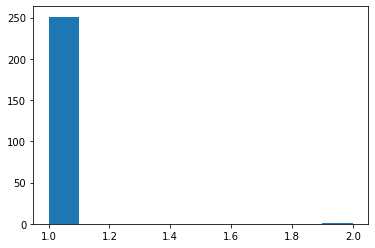

In [13]:
num_vars_per_cell = (out_donors_df>t).sum(axis=1)
#remove 0s
plt.hist(num_vars_per_cell[num_vars_per_cell!=0])
#plt.xscale('log')